In [59]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [61]:
df = pd.read_csv("/content/drive/MyDrive/MIT Critical Datathon Team 1/data/balanced_df.csv")
test = pd.read_csv("/content/drive/MyDrive/MIT Critical Datathon Team 1/data/MIMIC_IV.csv")

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import pickle

# Prepare the data
X = df[['race', 'gender', 'insurance', 'language', 'SpO2', 'SaO2']]
y = df['hidden_hypoxemia']


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encoding for categorical variables
enc = OneHotEncoder(handle_unknown='ignore')  
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)

print(X_train.shape)

# Create a bagging classifier with decision trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

# Train the model
bag_clf.fit(X_train, y_train)

# Make predictions
y_pred = bag_clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# # Save the model
# joblib.dump(bag_clf, 'bag_clf.pkl')
# # Save the encoder
# joblib.dump(enc, 'encoder.pkl')

with open('bag_clf.pkl', 'wb') as file:
    pickle.dump(bag_clf, file)

with open('encoder.pkl', 'wb') as file:
    pickle.dump(enc, file)

with open('X_train_df.pkl', 'wb') as file:
    pickle.dump(X_train, file)



(2292, 103)
Accuracy: 0.987783595113438
Confusion Matrix:
 [[566   0]
 [  7   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       566
           1       0.00      0.00      0.00         7

    accuracy                           0.99       573
   macro avg       0.49      0.50      0.50       573
weighted avg       0.98      0.99      0.98       573



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


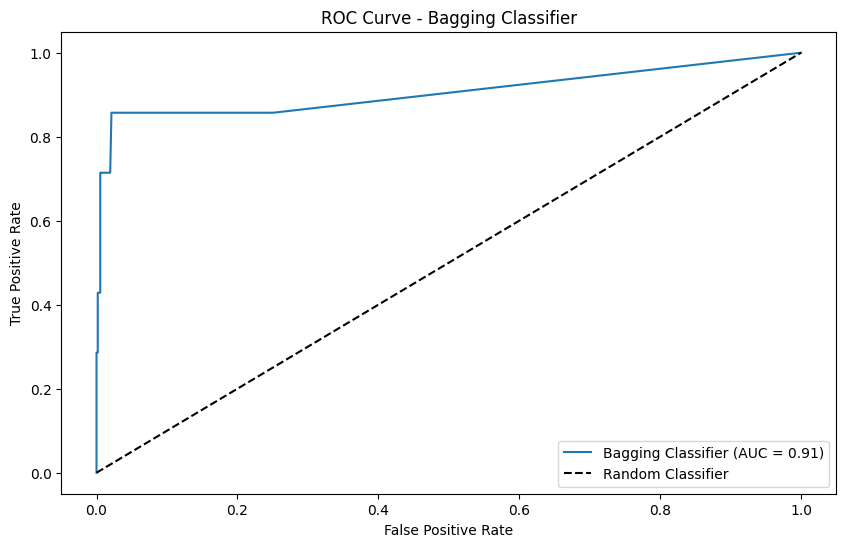

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prepare the data
X = df[['race', 'gender', 'insurance', 'language', 'SpO2', 'SaO2']]
y = df['hidden_hypoxemia']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encoding for categorical variables
enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)

# Create a bagging classifier with decision trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

# Train the model
bag_clf.fit(X_train, y_train)

# Calculate the predicted probabilities for the positive class (class 1)
y_prob = bag_clf.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and the AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='Bagging Classifier (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bagging Classifier')
plt.legend(loc='lower right')
plt.show()


In [63]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack

def align_test_with_train(train, test):
    """
    Aligns the test dataset with the training dataset.

    Args:
        train (pd.DataFrame or scipy.sparse.csr_matrix): Training dataset.
        test (pd.DataFrame or scipy.sparse.csr_matrix): Test dataset.

    Returns:
        test_aligned (pd.DataFrame or scipy.sparse.csr_matrix): Test dataset aligned with training dataset.
    """
    if isinstance(train, pd.DataFrame):
        train_cols = train.columns
        test_cols = test.columns

        # Get missing columns in the training set
        missing_cols = set(train_cols) - set(test_cols)

        # Add missing columns to the test set with default values
        for c in missing_cols:
            test[c] = 0

        # Reorder the columns in the test set to match the order in the training set
        test_aligned = test[train_cols]

        return test_aligned
    elif isinstance(train, csr_matrix):
        num_missing_cols = train.shape[1] - test.shape[1]
        missing_cols = csr_matrix((test.shape[0], num_missing_cols))
        test_aligned = hstack([test, missing_cols], format='csr')
        return test_aligned
    else:
        raise ValueError("Unsupported data type. The train and test datasets should be either pandas DataFrames "
                         "or scipy sparse matrices.")



# Load the trained model
with open('bag_clf.pkl', 'rb') as file:
    bag_clf = pickle.load(file)

# Load the encoder
with open('encoder.pkl', 'rb') as file:
    enc = pickle.load(file)

# Load the transformed training data
with open('X_train_df.pkl', 'rb') as file:
    X_train_df = pickle.load(file)

# Prepare the test data
X_test = test[['race', 'gender', 'insurance', 'language', 'SpO2', 'SaO2']]
y_test = test['hidden_hypoxemia']

# One-hot encoding for categorical variables
X_test_enc = enc.transform(X_test).toarray()  # Convert to dense matrix

# Get feature names based on the original data
feature_names = enc.get_feature_names_out(input_features=X_test.columns)

# Convert the encoded test data into a DataFrame
X_test_df = pd.DataFrame(X_test_enc, columns=feature_names)

# Align the test data with the train data
X_test_df_aligned = align_test_with_train(X_train_df, X_test_df)

# Make predictions
y_pred = bag_clf.predict(X_test_df_aligned)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9806594373876792
Confusion Matrix:
 [[80215     0]
 [ 1582     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     80215
           1       0.00      0.00      0.00      1582

    accuracy                           0.98     81797
   macro avg       0.49      0.50      0.50     81797
weighted avg       0.96      0.98      0.97     81797



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test on Workshop 1 